# Patent Citation Network

U.S. patent dataset is maintained by the [National Bureau of Economic Research](http://www.nber.org/). The data set spans 37 years (January 1, 1963 to December 30, 1999), and includes all the utility patents granted during that period, totaling 3,923,922 patents. The citation graph includes all citations made by patents granted between 1975 and 1999, totaling 16,522,438 citations. For the patents dataset there are 1,803,511 nodes for which we have no information about their citations (we only have the in-links).

The data was originally released by [NBER](http://www.nber.org/patents/). The dataset can be found at this link: [Stanford Patent Citation Network](https://snap.stanford.edu/data/cit-Patents.html)

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

!pip install -q node2vec
from node2vec import Node2Vec

## Import data

In [2]:
patent = pd.read_csv(
    "http://snap.stanford.edu/data/cit-Patents.txt.gz",
    compression="gzip",
    sep="\t",
    names=["start_node", "end_node"],
    skiprows=5
)

In [3]:
patent.head()

,start_node,end_node
0,3858241,1324234
1,3858241,3398406
2,3858241,3557384
3,3858241,3634889
4,3858242,1515701


In [4]:
patent.shape

(16518947, 2)

## Build Recommendation System

build a recommendation system based on Node2Vec with the patent information, remember to do a descriptive analysis and apply visualizations.

Also, remember that when making a recommendation about which patent should be associated with another, make a visualization of the recommendation.

In [5]:
import networkx as nx

# Crear un grafo dirigido a partir de los datos de citas
G = nx.from_pandas_edgelist(patent, source='start_node', target='end_node', create_using=nx.DiGraph())
print("Número total de nodos:", G.number_of_nodes())
print("Número total de aristas:", G.number_of_edges())


Número total de nodos: 3774767
Número total de aristas: 16518947


In [6]:
degrees = dict(G.degree())
high_degree_nodes = sorted(degrees, key=degrees.get, reverse=True)[:5]  # Los 5 nodos con mayor grado


In [7]:
print()
print("Los 5 nodos con mayor grado son:")
for node in high_degree_nodes:
    print(f"Nodo: {node}, Grado: {degrees[node]}")


Los 5 nodos con mayor grado son:
Nodo: 4723129, Grado: 793
Nodo: 5795784, Grado: 770
Nodo: 5887243, Grado: 745
Nodo: 5856194, Grado: 738
Nodo: 4463359, Grado: 725


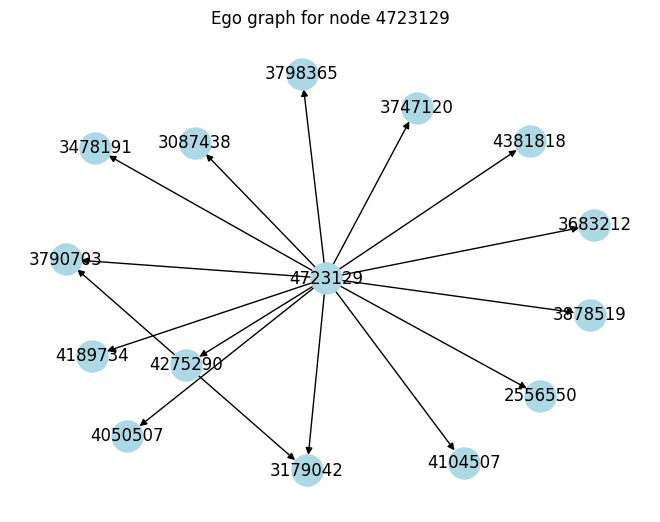

In [8]:
ego_node = 4723129

ego_graph = nx.ego_graph(G, ego_node)

import matplotlib.pyplot as plt

pos = nx.spring_layout(ego_graph)
nx.draw(ego_graph, pos, with_labels=True, node_color='lightblue', node_size=500, arrows=True)
plt.title(f'Ego graph for node {ego_node}')
plt.show()

In [12]:
#crear modelo node2vect
node2vec = Node2Vec(ego_graph, dimensions=64, walk_length=30, num_walks=1000, workers=4)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/15 [00:00<?, ?it/s]

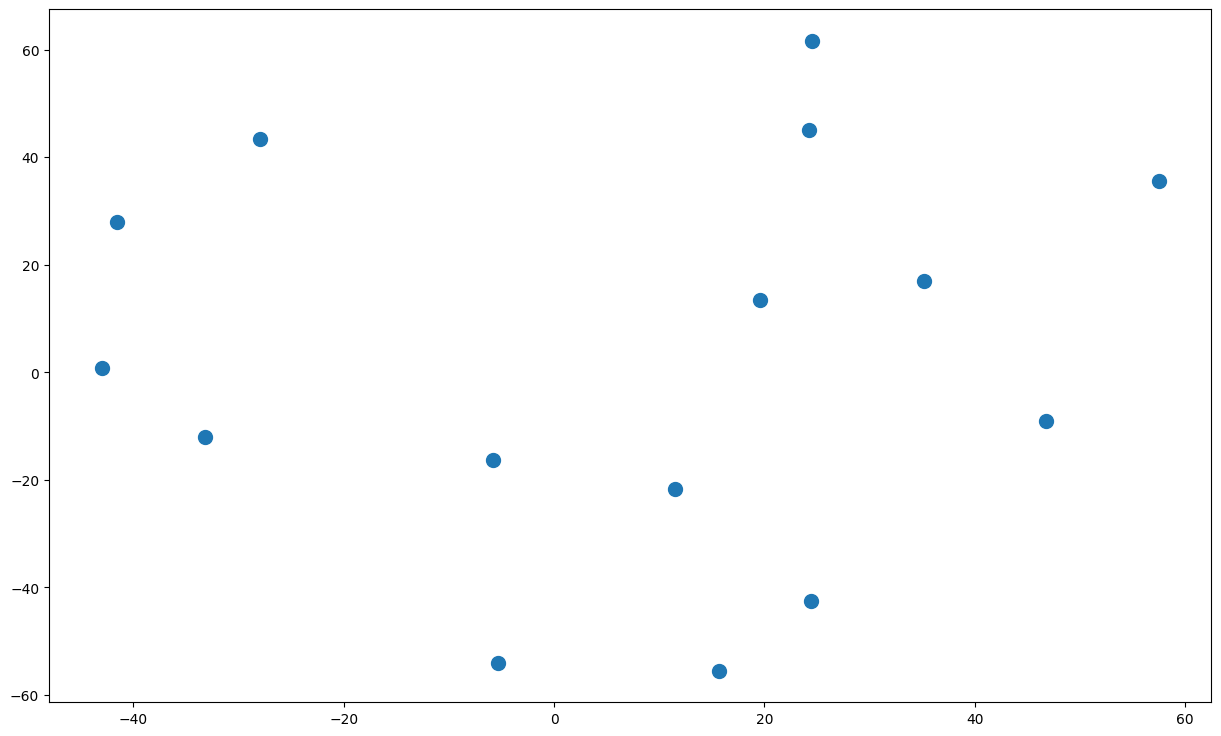

In [13]:
from sklearn.manifold import TSNE
import numpy as np

# Preprocess word vectors and label
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in model.wv.index_to_key])

tsne = TSNE(n_components=2,
            perplexity=5,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

# Plot TSNE
plt.figure(figsize=(15, 9))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100)
plt.show()

In [14]:
def recommend(patent_id):

  if str(patent_id) not in model.wv.index_to_key:
    print(f"La patente {patent_id} no está presente en el modelo.")
    return []

  patent_vector = model.wv.get_vector(str(patent_id))

  similarities = model.wv.cosine_similarities(patent_vector, model.wv.vectors)

  similar_patents = sorted(zip(model.wv.index_to_key, similarities), key=lambda x: x[1], reverse=True)

  recommendations = [patent for patent, similarity in similar_patents if int(patent) != patent_id][:10]

  # Crear una visualización de las recomendaciones
  recommendation_nodes = [patent_id] + [int(patent) for patent in recommendations]
  recommendation_graph = G.subgraph(recommendation_nodes)
  pos = nx.spring_layout(recommendation_graph)
  nx.draw(recommendation_graph, pos, with_labels=True, node_color='lightblue', node_size=500, arrows=True)
  plt.title(f'Recomendaciones para la patente {patent_id}')
  plt.show()

  return recommendations

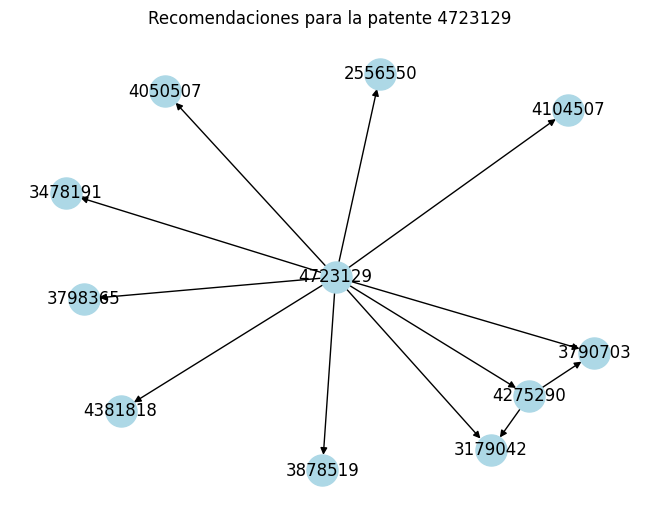

['4275290',
 '3790703',
 '4104507',
 '4050507',
 '3478191',
 '3179042',
 '4381818',
 '3878519',
 '2556550',
 '3798365']

In [15]:
recommend(4723129)

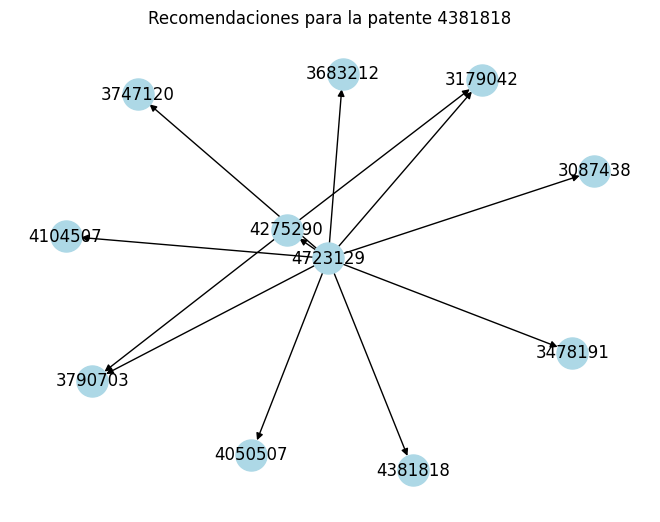

['3087438',
 '3478191',
 '3179042',
 '4723129',
 '4104507',
 '3790703',
 '4050507',
 '3683212',
 '3747120',
 '4275290']

In [16]:
recommend(4381818)